In [24]:
# noscript
!jupyter nbconvert --RegexRemovePreprocessor.patterns="['# ?noscript']" --TemplateExporter.exclude_markdown=True --to python compare_metrics_over_datasets.ipynb --output count_bins_small.py

[NbConvertApp] Converting notebook compare_metrics_over_datasets.ipynb to python
[NbConvertApp] Writing 20360 bytes to count_bins_small.py


In [103]:
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt
import tabulate

import openml

import sklearn.metrics
import sklearn.ensemble
import sklearn.svm
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.base
import sklearn.utils
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.neural_network
import sklearn.tree
import xgboost

from ridgereliability import plots, metrics

import os
import multiprocessing
import logging
import time
from joblib import load, dump

In [104]:
def is_notebook():
    try:
        from IPython import get_ipython
        return get_ipython().__class__.__name__ == 'ZMQInteractiveShell'
    except ModuleNotFoundError:
        return False

In [105]:
if is_notebook():
    n_procs = multiprocessing.cpu_count()//2
    random_tasks = 0
else:
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("--n-processes", type=int, required=True)
    parser.add_argument("--random-tasks", type=int, default=0)
    args = parser.parse_args()
    n_procs = args.n_processes
    random_tasks = args.random_tasks

In [106]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(name)s %(asctime)s - %(message)s')
logging.captureWarnings(True)
logging.getLogger("openml").setLevel(logging.ERROR)

class NoRequestFilter(logging.Filter):
    def filter(self, record):
        return not "request for the URL" in record.getMessage()

logging.getLogger("root").addFilter(NoRequestFilter())
logging.getLogger().addFilter(NoRequestFilter())

In [107]:
numpy.random.seed(42)

# Compare metrics over datasets

In this notebook we collect calibration estimates for several models and datasets. The estimates are computed with the Expected Calibration Error (ECE), Balanced-ECE, and Posterior Expected Accuracy-based Calibration Error (PEACE). A list of manually selected datasets is available, but in final experiments we used randomly selected datasets from the OpenML repository.

Tested models:
- Random Forest
- SVM
- Logistic Regression
- Gaussian Naive Bayes
- MLP
- AdaBoost
- Decision Tree

Selected datasets (from Open ML):
- [eeg-eye-state](https://www.openml.org/d/1471), task [9983](https://www.openml.org/t/9983)
- [Phoneme](https://www.openml.org/d/1489), task [9952](https://www.openml.org/t/9952)
- [mozilla4](https://www.openml.org/d/1046), task [3899](https://www.openml.org/t/3899)
- [electricity](https://www.openml.org/d/151), task [219](https://www.openml.org/t/219)
- [Magic Telescope](https://www.openml.org/d/1120), task [3954](https://www.openml.org/t/3954)
- [artificial characters](https://www.openml.org/d/1459), task [14964](https://www.openml.org/t/14964)
- [pendigits](https://www.openml.org/d/32), task [32](https://www.openml.org/t/32)
- [letter](https://www.openml.org/d/6), task [6](https://www.openml.org/t/6)
- [JapaneseVowels](https://www.openml.org/d/375), task [3510](https://www.openml.org/t/3510)
- [glass](https://www.openml.org/d/41), task [40](https://www.openml.org/t/40)
- [micro-mass](https://www.openml.org/d/1515), task [9950](https://www.openml.org/t/9950)
- [vehicle](https://www.openml.org/d/54), task [53](https://www.openml.org/t/53)
- [synthetic-control](https://www.openml.org/d/377), task [3512](https://www.openml.org/t/3512)
- [mfeat-factors](https://www.openml.org/d/12), task [12](https://www.openml.org/t/12)
- [OVA_breast](https://www.openml.org/d/1128), task [3962](https://www.openml.org/d/1128)
- [sonar](https://www.openml.org/d/40), task [39](https://www.openml.org/t/39)
- [visualizing_livestock](https://www.openml.org/d/685), task [3577](https://www.openml.org/t/3577)
- [spectrometer](https://www.openml.org/d/313), task [145682](https://www.openml.org/t/145682)
- [disclosure_z](https://www.openml.org/d/931), task [3794](https://www.openml.org/t/3794)
- [mfeat-pixel](https://www.openml.org/d/40979), task [146824](https://www.openml.org/t/146824)

## Datasets

First of all, we need to be able to load and preprocess multiple datasets appropriately to prepare it for classification. 
To this end we implement a function that will load a dataset and classification task from OpenML.

In [9]:
def find_random_task(selected_tasks):
    tries = 0
    while True:
        df = openml.tasks.list_tasks(task_type_id=1, offset=tries*1000, output_format="dataframe", size=1000, status="active", number_missing_values=0)
        tries += 1
        if "NumberOfInstances" in df:
            df = df[(df["NumberOfInstances"] > 2000) & (df["NumberOfInstances"] < 10000)]
            df = df[~df["tid"].isin(list(selected_tasks))]
            if len(df) > 0:
                task = df.sample(n=1).iloc[0]["tid"]
                selected_tasks.append(task)
                return task

In [10]:
LARGE_TASKS = [  3919,   4230,   3601,     30,   3891,   4190,   1792,     43,
         1908,   3786,   2939,   3488,   3843,   3603,    266,   4193,
         3528,   3842,   3525,   3777,   1923,   1809,    275,   3638,
         3684,   1800,   1916,   1794,   2074,     36,   3672,   2120,
          288,   3594,   3712,   3618,   3586,   4229,   3917,   1925,
         3816,   1767,   3668,   1883,   3698,   3907,   4233,   3485,
         3531,   3627,   1822,   3524,   3821,   3681,   3892,   3950,
          233,    260,   3894,   4236,   3884,   3735,   4215,   2121,
          258,   3481,   3839,   3510,     58,   1910,   3591,     28,
          273,     45,      3,   1938,   1807,   4186, 126022,  14969,
       145945,  75100,   4308, 145855,   9898,   4612,  75203,  75216,
       145891, 145985,   9952,   9921,  75169, 145903,  75242,  75124,
        75138,  10091]

In [11]:
SMALL_TASKS = [4240, 4245, 1780,  248, 1896, 3891, 3934, 3611, 3837, 3763, 1784,
       2938,   12,  242, 3918, 3497, 3524, 3614, 3523,  246, 1923, 3925,
        277,   31, 3603, 3653, 3894,   52, 3058,  250, 4196, 3994,    3,
       3584,  252, 4200, 3527, 1787, 3778, 3993, 3841, 3959, 3996, 3846,
       4190, 3933,  275, 1927, 4234, 4238, 3997, 3520, 1892, 4241, 1811,
        266, 3521, 1806, 3635, 1916, 3730, 3806, 3710, 3892, 3657, 3775,
        270, 3491, 3716, 3753, 3676, 3788, 3538, 4235, 3585, 3731, 3702,
       3917, 3821,   45, 3689, 3598,  233, 3995, 2104, 3519, 3735, 1903,
       3777, 4243, 3828, 3733, 3056, 3583, 4225, 3695, 4198, 3617,  261]

In [12]:
DEBUG_TASKS = [4240, 4245]

In [13]:
if random_tasks > 0:
    TASKS = random_tasks
else:
    TASKS = SMALL_TASKS

In [11]:
def load_openml_task(task_id=None, selected_tasks=[]):
    
    while True:
        if task_id is None:
            curr_id = find_random_task(selected_tasks)
        else:
            curr_id = task_id

        try: 
            task = openml.tasks.get_task(curr_id)
            X, y = task.get_X_and_y("array")
            X, y = sklearn.utils.indexable(X, y)
            
            target_type = sklearn.utils.multiclass.type_of_target(y)
            if target_type not in ["binary", "multiclass"]:
                continue

            if hasattr(X, "toarray"):
                X = X.toarray()
            if hasattr(y, "toarray"):
                y = y.toarray()

            X = sklearn.preprocessing.OrdinalEncoder().fit_transform(X)

            n_repeats, n_folds, n_samples = task.get_split_dimensions()
            
            if n_folds > 10:
                continue

            folds = numpy.full((len(X)), dtype=int, fill_value=-1)
            for fold_idx in range(n_folds):
                _, test_indices = task.get_train_test_split_indices(
                    repeat=0,
                    fold=fold_idx,
                    sample=0,
                )

                folds[test_indices] = fold_idx

            splitter = sklearn.model_selection.PredefinedSplit(folds)

            return X, y, splitter, curr_id
        except Exception as e:
            if task_id is not None:
                raise e

In [ ]:
# noscript
from tqdm.notebook import trange
iter_tasks = []
tmp_tasks = []
for i in trange(100):
    _, _, _, task = load_openml_task(selected_tasks=tmp_tasks)
    iter_tasks.append(task)

In [20]:
# noscript
X, y, splitter, task_id = load_openml_task(DEBUG_TASKS[1])

In [ ]:
# noscript
X, y, splitter, task_id = load_openml_task()

## Getting calibration metrics

For each dataset we fit and evaluate multiple models. We record calibration metrics (ECE, ECE-balanced, PEACE), and some performance metrics (balanced accuracy, F1-score, accuracy). To this end we implement a function that runs this procedure for one model on one OpenML task.

In [12]:
MODELS = {
    "rf": sklearn.ensemble.RandomForestClassifier(),
    "logreg": sklearn.linear_model.LogisticRegression(max_iter=1000),
    "nb": sklearn.naive_bayes.GaussianNB(),
    "mlp": sklearn.neural_network.MLPClassifier(max_iter=1000),
    "adaboost": sklearn.ensemble.AdaBoostClassifier(n_estimators=500),
    "dectree": sklearn.tree.DecisionTreeClassifier(),
    "svm": sklearn.linear_model.SGDClassifier(loss="modified_huber", max_iter=1000)
#     "xgb": xgboost.XGBClassifier(tree_method="gpu_hist")
}

In [162]:
# noscript
MODELS = {
    "adaboost_perceptron": sklearn.ensemble.AdaBoostClassifier(base_estimator=sklearn.linear_model.Perceptron(), n_estimators=500)
}

In [178]:
# noscript
MODELS = {
    "xgb": xgboost.XGBClassifier(tree_method="gpu_hist")
}

In [ ]:
# noscript
MODELS = {
    "svm": sklearn.ensemble.BaggingClassifier(sklearn.svm.SVC(probability=True)),
    "logreg": sklearn.ensemble.BaggingClassifier(sklearn.linear_model.LogisticRegression(max_iter=1000)),
    "nb": sklearn.ensemble.BaggingClassifier(sklearn.naive_bayes.GaussianNB()),
    "mlp": sklearn.ensemble.BaggingClassifier(sklearn.neural_network.MLPClassifier(max_iter=1000)),
    "dectree": sklearn.ensemble.BaggingClassifier(sklearn.tree.DecisionTreeClassifier())
}

In [ ]:
# noscript
MODELS = {
    "dummy": sklearn.dummy.DummyClassifier(strategy="prior")
}

In [13]:
def fit_and_predict(model_id, Xt, yt, Xv, yv):
    # get and fit fresh model
    model = sklearn.base.clone(MODELS[model_id])
    model.fit(Xt, yt)

    # predict on test
    y_probs = model.predict_proba(Xv)
    y_preds = model.predict(Xv)
    
    return y_probs, y_preds, yv

In [14]:
def get_cv_metrics_for_model_and_task(model_id, task_id, pool, selected_tasks):
    X, y, splitter, task_id = load_openml_task(task_id, selected_tasks=selected_tasks) # repeated runs will use cached data
    
    row = {
        "model_id": model_id,
        "task_id": task_id,
    }

    promises = []
    for i, (train_idx, test_idx) in enumerate(splitter.split()):

        # split data
        Xt, yt = X[train_idx], y[train_idx]
        Xv, yv = X[test_idx], y[test_idx]

        promise = pool.apply_async(
            fit_and_predict,
            (model_id, Xt, yt, Xv, yv)
        )
        promises.append(promise)

    logging.info(f"Promises for single cv: {len(promises)}")
    return row, promises

## Data collection over all datasets and models

In [22]:
with multiprocessing.Pool(processes=n_procs) as pool:

    start_at = 0

    output_file = f"metrics_{int(time.time())}.dat"
    logging.info(f"Output to {output_file}")
    
    if type(TASKS) is int:
        iter_tasks = []
        tmp_tasks = []
        for i in range(TASKS):
            _, _, _, task = load_openml_task(selected_tasks=tmp_tasks)
            iter_tasks.append(task)
    else:
        iter_tasks = TASKS[start_at:]
        
    logging.info(f"Tasks: {iter_tasks}")
    
    data = []
    for model_id in MODELS.keys():
        
        logging.info(f"Start submitting promises for {model_id}")
        
        promises = []
        for task_id in iter_tasks:
            row, tmp = get_cv_metrics_for_model_and_task(model_id, task_id, pool, [])
            promises.append((row, tmp))
            logging.info(f"{len(promises)} tasks submitted to pool ({model_id})")
        logging.info(f"All {len(promises)} tasks submitted to pool ({model_id})")

        for i, (row, promise) in enumerate(promises):
            try:
                y_probs, y_preds, y_test = [], [], []
                for x in promise:
                    x = x.get()
                    y_probs.extend(x[0])
                    y_preds.extend(x[1])
                    y_test.extend(x[2])

                # stack fold results and compute metrics
                y_probs = numpy.array(y_probs)
                logging.debug(y_probs.shape)
                y_probs_max = y_probs.max(axis=1)
                y_preds = numpy.array(y_preds)
                y_test = numpy.array(y_test)

                bins = "count"
                row.update({
                    "accuracy": sklearn.metrics.accuracy_score(y_test, y_preds),
                    "balanced_accuracy": sklearn.metrics.balanced_accuracy_score(y_test, y_preds),
                    "f1": sklearn.metrics.f1_score(y_test, y_preds, average="weighted"),
                    'ece_count': metrics.ece(y_probs_max, y_preds, y_test, bins=bins),
                    'ece_balanced_count': metrics.ece(y_probs_max, y_preds, y_test, balanced=True, bins=bins),
                    'peace_count': metrics.peace(y_probs_max, y_preds, y_test, bins=bins),
#                     'class_wise_ece': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.ece, bins=bins),
#                     'class_wise_peace': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.peace, bins=bins)
                })

                # update data and dump intermediate dataframe
                data.append(row)
                df = pandas.DataFrame(data)
                dump(df, output_file)

                logging.info(f"Finished tasks: {i+1}/{len(promises)} ({(i+1)/len(promises)*100:.2f}%)")
            except Exception:
                logging.exception("Exception when collecting results")

INFO: root 2020-10-08 17:21:10,193 - Output to metrics_1602170470.dat
INFO: root 2020-10-08 17:21:10,194 - Tasks: [4240, 4245]
INFO: root 2020-10-08 17:21:10,194 - Start submitting promises for rf
INFO: root 2020-10-08 17:21:11,665 - Promises for single cv: 10
INFO: root 2020-10-08 17:21:11,665 - 1 tasks submitted to pool (rf)
INFO: root 2020-10-08 17:21:11,684 - Promises for single cv: 10
INFO: root 2020-10-08 17:21:11,684 - 2 tasks submitted to pool (rf)
INFO: root 2020-10-08 17:21:11,685 - All 2 tasks submitted to pool (rf)
INFO: root 2020-10-08 17:21:13,762 - Finished tasks: 1/2 (50.00%)
INFO: root 2020-10-08 17:21:13,795 - Finished tasks: 2/2 (100.00%)
INFO: root 2020-10-08 17:21:13,795 - Start submitting promises for svm
INFO: root 2020-10-08 17:21:15,165 - Promises for single cv: 10
INFO: root 2020-10-08 17:21:15,166 - 1 tasks submitted to pool (svm)
INFO: root 2020-10-08 17:21:15,194 - Promises for single cv: 10
INFO: root 2020-10-08 17:21:15,195 - 2 tasks submitted to pool (sv

In [ ]:
if not is_notebook():
    exit()

# Analysis

In [157]:
tmp_df = load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1601995877.dat")
tmp_df["model_id"] = "bagged_" + tmp_df["model_id"]

In [19]:
df = pandas.concat([
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1601494658.dat"),
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602009416.dat"),
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602065288.dat"),
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602080372.dat"),
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602142050.dat"),
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602148932.dat"),
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602158698.dat"),
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602184261.dat")
])

In [108]:
df = pandas.concat([
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1601494658.dat"),
    load("/home/maximl/Data/Experiment_data/results/riverrel/datasets/random_openml/metrics_1602238194.dat")[["ece_count", "ece_balanced_count", "peace_count"]]
], axis=1)

In [109]:
df.head()

,model_id,task_id,accuracy,balanced_accuracy,f1,ece,ece_balanced,peace,class_wise_ece,class_wise_peace,ece_count,ece_balanced_count,peace_count
0,rf,4240,0.933941,0.769999,0.925897,0.248235,0.219843,0.157723,0.385313,0.275375,0.246025,0.220359,0.161192
1,rf,4245,0.708333,0.676740,0.707505,0.117167,0.128374,0.145745,0.140497,0.163317,0.137000,0.159639,0.166367
2,rf,1780,0.950500,0.950500,0.950496,0.319755,0.320675,0.278961,0.321375,0.283606,0.327790,0.326902,0.267201
3,rf,248,0.724242,0.718477,0.722455,0.082031,0.130122,0.167806,0.151381,0.160322,0.079514,0.095305,0.196955
4,rf,1896,0.961500,0.961500,0.961454,0.283065,0.280614,0.240080,0.284469,0.246530,0.287410,0.285972,0.229096


In [110]:
df = df[~df.duplicated(["model_id", "task_id"])]

In [111]:
for idx, group_df in df.groupby("model_id"):
    a = sum([(t == group_df["task_id"]).any() for t in LARGE_TASKS])
    b = sum([(t == group_df["task_id"]).any() for t in SMALL_TASKS])
    print(idx, a, b)

adaboost 17 99
dectree 17 99
logreg 17 99
mlp 17 99
nb 17 99
rf 17 99
svm 17 99


In [112]:
all_tasks = set(SMALL_TASKS + LARGE_TASKS)
for idx, group_df in df.groupby("model_id"):
    all_tasks = all_tasks.intersection(group_df["task_id"])

In [113]:
df = df[df["task_id"].isin(all_tasks)]

In [114]:
df.columns = ["model_id", "task_id", "Accuracy", "Balanced Accuracy", "F1", "ECE", "Balanced ECE", "PEACE", "cw-ECE", "cw-PEACE", "ECE (c)", "Balanced ECE (c)", "PEACE (c)"]

In [115]:
def get_longform(df, cols=None, subject_cols=None):
    dfs = []
    
    if cols is None:
        cols = df.columns
    
    for col in cols:
        tmp_df = pandas.DataFrame(dict(        
            value=df[col], 
            metric=col,   
        ))
        for col2 in set(df.columns) - set(cols):
            tmp_df[col2] = df[col2]
            
        if subject_cols is not None:
            tmp_df["subject"] = df[subject_cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
            
        dfs.append(tmp_df)
        
    return pandas.concat(dfs)

In [116]:
long_df = get_longform(df, df.columns[2:], ["model_id", "task_id"])

In [117]:
long_df.shape

(7623, 5)

In [118]:
long_df.head()

,value,metric,model_id,task_id,subject
0,0.933941,Accuracy,rf,4240,rf_4240
1,0.708333,Accuracy,rf,4245,rf_4245
2,0.950500,Accuracy,rf,1780,rf_1780
3,0.724242,Accuracy,rf,248,rf_248
4,0.961500,Accuracy,rf,1896,rf_1896


In [119]:
seaborn.set_theme("paper", "whitegrid", font_scale=1.5)

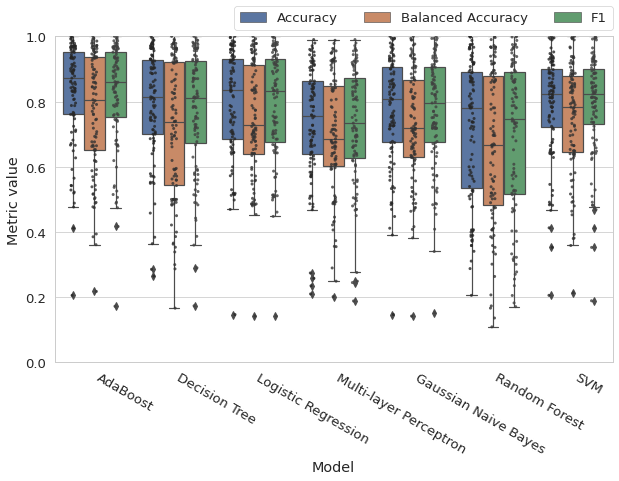

In [120]:
fig, ax = plt.subplots(figsize=(10, 6))
seaborn.boxplot(
    data=long_df[long_df["metric"].isin(["Accuracy", "Balanced Accuracy", "F1"])], 
    x="model_id", y="value", hue="metric", saturation=.7, ax=ax
)
seaborn.stripplot(
    data=long_df[long_df["metric"].isin(["Accuracy", "Balanced Accuracy", "F1"])], 
    x="model_id", y="value", hue="metric", dodge=True, color=".25", s=3, alpha=.8, ax=ax
)
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel("Model")
ax.set_ylabel("Metric value")
ax.set_ylim(0, 1)
ax.set_xticklabels(
    ["AdaBoost", "Decision Tree", "Logistic Regression", "Multi-layer Perceptron", "Gaussian Naive Bayes", "Random Forest", "SVM", "XGBoost"],
    rotation=-30, ha="left")

plt.legend(handles[:3], labels[:3], bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right',
           ncol=3, borderaxespad=0.)
# plt.savefig("performance.pdf", bbox_inches="tight")

In [121]:
cols = ["ECE", "Balanced ECE", "PEACE", "ECE (c)", "Balanced ECE (c)", "PEACE (c)"]

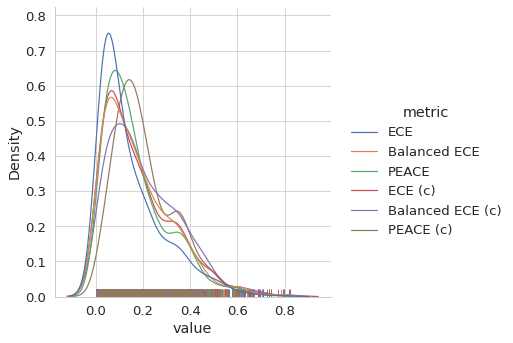

In [122]:
seaborn.displot(data=long_df[long_df["metric"].isin(cols)], x="value", hue="metric", rug=True, kind="kde")

Text(0, 0.5, 'Metric value')

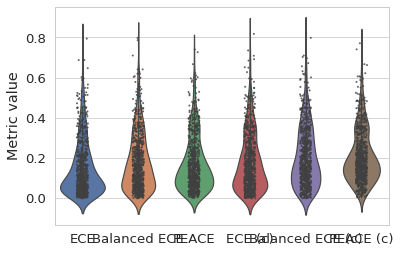

In [123]:
g = seaborn.violinplot(data=long_df[long_df["metric"].isin(cols)], y="value", x="metric")
seaborn.stripplot(data=long_df[long_df["metric"].isin(cols)], x="metric", y="value", color=".25", s=2, alpha=.8)
g.set_xlabel("")
g.set_ylabel("Metric value")
# plt.savefig("metrics.pdf")

In [124]:
(df["PEACE"] - df["ECE"]).mean()

0.021519298844717573

## Statistical testing

In [125]:
import scipy.stats
import scikit_posthocs as sp

### Friedman

In [126]:
df.head()

,model_id,task_id,Accuracy,Balanced Accuracy,F1,ECE,Balanced ECE,PEACE,cw-ECE,cw-PEACE,ECE (c),Balanced ECE (c),PEACE (c)
0,rf,4240,0.933941,0.769999,0.925897,0.248235,0.219843,0.157723,0.385313,0.275375,0.246025,0.220359,0.161192
1,rf,4245,0.708333,0.676740,0.707505,0.117167,0.128374,0.145745,0.140497,0.163317,0.137000,0.159639,0.166367
2,rf,1780,0.950500,0.950500,0.950496,0.319755,0.320675,0.278961,0.321375,0.283606,0.327790,0.326902,0.267201
3,rf,248,0.724242,0.718477,0.722455,0.082031,0.130122,0.167806,0.151381,0.160322,0.079514,0.095305,0.196955
4,rf,1896,0.961500,0.961500,0.961454,0.283065,0.280614,0.240080,0.284469,0.246530,0.287410,0.285972,0.229096


In [127]:
def map_stars(p):
    if p < 0.001:
        return "*"*3
    elif p < 0.01:
        return "*"*2
    elif p < 0.05:
        return "*"
    else:
        return ""

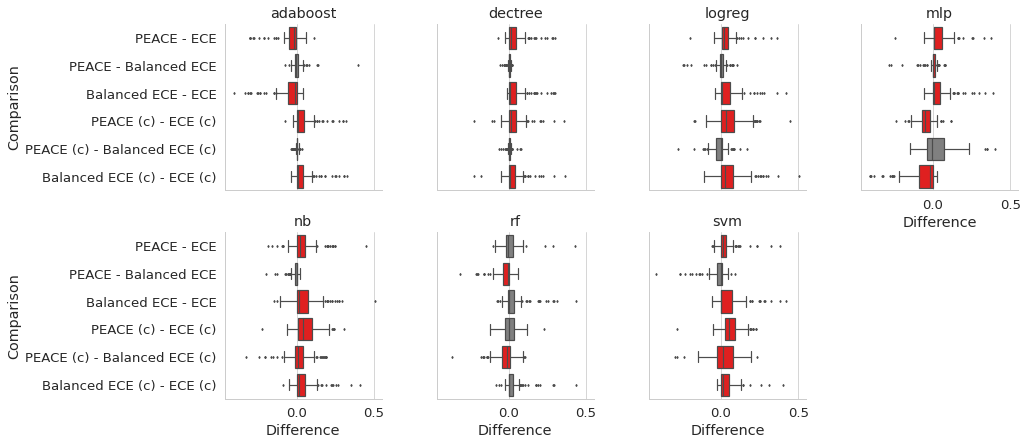

In [128]:
grid = seaborn.FacetGrid(data=df, col="model_id", col_wrap=4)
table_data = [["PEACE - ECE"], ["PEACE - Balanced ECE"], ["Balanced ECE - ECE"]]
for ax, (idx, model_df) in zip(grid.axes, df.groupby("model_id")):
    
    diffs = [
#         ("ECE (c)", "ECE"),
#         ("Balanced ECE (c)", "Balanced ECE"),
#         ("PEACE (c)", "PEACE"),
#         ("PEACE (c)", "Balanced ECE (c)")
        ("PEACE", "ECE"),
        ("PEACE", "Balanced ECE"),
        ("Balanced ECE", "ECE"),
        ("PEACE (c)", "ECE (c)"),
        ("PEACE (c)", "Balanced ECE (c)"),
        ("Balanced ECE (c)", "ECE (c)")
    ]
    
    diff_df = pandas.concat([
        pandas.DataFrame({"value": model_df[d1] - model_df[d2], "diff": f"{d1} - {d2}"})
        for d1, d2 in diffs
    ])
    
    data = model_df.loc[:, cols + ["task_id"]]
    test = scipy.stats.friedmanchisquare(*data.iloc[:, :len(cols)].values.tolist())
    if test.pvalue < 0.05:
        l = get_longform(data.drop(columns=["task_id"]))
        a = sp.posthoc_wilcoxon(a=l, val_col="value", group_col="metric", p_adjust="holm")
        
        colormap = a.copy()
        colormap[a < 0.05] = "red"
        colormap[a >= 0.05] = "grey"
        colors = [colormap[d1][d2] for d1, d2 in diffs]
    else:
        colors = ["grey"]*len(diffs)

#     tmp_df = diff_df.groupby("diff").aggregate("mean")
#     for i, (col1, col2) in enumerate([["PEACE", "ECE"], ["PEACE", "Balanced ECE"], ["Balanced ECE", "ECE"]]):
#         table_data[i].append("$%+.3f$ %s" % (tmp_df.loc[f"{col1} - {col2}"], map_stars(a[col1][col2])))
    
    ax.set_title(idx)
    seaborn.boxplot(data=diff_df, y="diff", x="value", orient="h", ax=ax, palette=seaborn.color_palette(colors), fliersize=1.5)

grid.set_axis_labels("Difference", "Comparison")
plt.savefig("pairwise_comparisons.pdf", bbox_inches="tight")

In [ ]:
headers = ["AdaBoost", "DecTree", "LogReg", "MLP", "GNB", "RF", "SVM"]
print(tabulate.tabulate(table_data, headers=headers, tablefmt="latex").replace("\\$", "$"))

In [ ]:
seaborn.catplot(data=long_df[long_df["metric"].isin(cols)], x="metric", y="value", col="model_id", kind="violin")

# Randomly selected datasets

In [ ]:
def get_task_meta(task_id):
    task = openml.tasks.get_task(task_id)
    d = task.get_dataset()
    return {
        "Task ID": task_id,
        "# classes": d.qualities["NumberOfClasses"],
        "# features":  d.qualities["NumberOfFeatures"],
        "# instances": d.qualities["NumberOfInstances"],
        "Dataset ID": d.dataset_id,
        "Dataset name": d.name,
        "Dataset URL": d.openml_url,
        "Dataset version": d.version,
        "Dataset creator": ", ".join(d.creator) if type(d.creator) is list else d.creator
    }

In [ ]:
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    tasks = pool.map(get_task_meta, df["task_id"].unique())

In [ ]:
tasks = pandas.DataFrame(tasks)
tasks.head()

In [ ]:
with open("task_table.tex", "w") as fp:
    fp.write(tabulate.tabulate(
        tasks[["Task ID", "Dataset ID", "Dataset name", "Dataset version", "# classes", "# features", "# instances"]].values, 
        headers=["Task ID", "Dataset ID", "Dataset name", "Dataset version", "# classes", "# features", "# instances"],
        tablefmt="latex"))

In [ ]:
table = tasks.merge(df, right_on="task_id", left_on="Task ID")

In [ ]:
tasks["# instances"].describe()

In [ ]:
table["PEACE-ECE"] = table["PEACE"] - table["ECE"]

In [ ]:
table["PEACE-balECE"] = table["PEACE"] - table["Balanced ECE"]
table["PEACE>=balECE"] = table["PEACE"] >= table["Balanced ECE"]

In [ ]:
selector = table["model_id"] == "mlp"

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
seaborn.regplot(data=table, x="# instances", y="PEACE-balECE", ax=ax[0])
seaborn.regplot(data=table, x="# features", y="PEACE-balECE", ax=ax[1])
seaborn.regplot(data=table, x="# classes", y="PEACE-balECE", ax=ax[2])

In [ ]:
import statsmodels.api as sm

In [ ]:
X = pandas.concat([pandas.get_dummies(table["Task ID"]), pandas.get_dummies(table["model_id"]), table[["# instances", "# features", "# classes"]]], axis=1)

In [ ]:
model = sm.RLM(table["PEACE-balECE"], sm.add_constant(X))
res = model.fit()

In [ ]:
res.summary()

# AdaBoost

In [ ]:
from functools import partial

In [ ]:
row = grouped_df.iloc[(grouped_df["PEACE"] - grouped_df["ECE"]).sort_values().index[0]]

In [ ]:
def func(model):
    X, y, splitter, task_id = load_openml_task(row["task_id"])

    y_probs = [[]]*splitter.get_n_splits()
    y_preds = [[]]*splitter.get_n_splits()
    y_test = [[]]*splitter.get_n_splits()

    for i, (train_idx, test_idx) in enumerate(splitter.split()):
        # split data
        Xt, yt = X[train_idx], y[train_idx]
        Xv, yv = X[test_idx], y[test_idx]

        # train adaboost
        model_instance = model()
        model_instance.fit(Xt, yt)

        y_probs[i] = model_instance.predict_proba(Xv)
        y_preds[i] = model_instance.predict(Xv)
        y_test[i] = yv
        
    return y_probs, y_preds, y_test

In [ ]:
ada_data = func(sklearn.ensemble.AdaBoostClassifier)

In [ ]:
logreg_data = func(partial(sklearn.linear_model.LogisticRegression, max_iter=1000))

In [ ]:
svm_data = func(partial(sklearn.svm.SVC, max_iter=1000, probability=True))

In [ ]:
mlp_data = func(partial(sklearn.neural_network.MLPClassifier, max_iter=1000))

In [ ]:
rf_data = func(sklearn.ensemble.RandomForestClassifier)

In [ ]:
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20, 4))

for ax, data in zip(axes, [ada_data, logreg_data, svm_data, mlp_data, rf_data]):
    y_probs = numpy.hstack([p.max(axis=1) for p in data[0]])
    y_preds = numpy.hstack(data[1])
    y_test = numpy.hstack(data[2])
    ax.set_title(f"ECE: {metrics.ece(y_probs, y_preds, y_test, bins=15):.3f}, PEACE: {metrics.peace(y_probs, y_preds, y_test, bins=15):.3f}")

    seaborn.histplot(y_probs, ax=ax, bins=numpy.histogram_bin_edges(y_probs, bins=15, range=(0,1)))

In [ ]:
plots.river_reliability_diagram(mlp_data[0][i].max(axis=1), mlp_data[1][i], mlp_data[2][i], bins=15)

In [ ]:
plots.river_reliability_diagram(logreg_data[0][i].max(axis=1), logreg_data[1][i], logreg_data[2][i], bins=15)

In [ ]:
plots.confidence_reliability_diagram(ada_data[0][i].max(axis=1), ada_data[1][i], ada_data[2][i], bins=15)

In [ ]:
plots.confidence_reliability_diagram(logreg_data[0][i].max(axis=1), logreg_data[1][i], logreg_data[2][i], bins=15)